In [1]:
!pip install yfinance stable-baselines3 matplotlib --quiet
!pip install --upgrade yfinance
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import gymnasium as gym # Import gymnasium instead of gym
import yfinance as yf
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_checker import check_env
import torch as th
import random

In [3]:
class SimplePortfolioEnv(gym.Env):
    def __init__(
        self,
        tickers=None,
        start_date='2020-01-01',
        end_date='2023-01-01',
        window_size=2,
        returns_df=None,           # <-- new parameter
    ):
        super(SimplePortfolioEnv, self).__init__()
        self.tickers = tickers or ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AMD']
        self.start_date = start_date
        self.end_date = end_date
        self.window_size = window_size

        # If the user passed in a precomputed returns_df, use it;
        # otherwise, download via yfinance
        if returns_df is not None:
            self.data = returns_df.copy()
        else:
            self.data = self.load_data()

        self.max_steps = max(1, len(self.data) - self.window_size)
        self.action_space = gym.spaces.Box(
            low=0, high=1, shape=(len(self.tickers),), dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size, len(self.tickers)), dtype=np.float32
        )

    def load_data(self):
        df = yf.download(self.tickers, start=self.start_date, end=self.end_date)['Close']
        df = df.ffill().bfill()
        returns = df.pct_change().dropna()
        if len(returns) < self.window_size + 1:
            raise ValueError(f"Not enough data ({len(returns)} rows) for window_size = {self.window_size}")
        return returns

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = np.random.randint(0, max(1, len(self.data) - self.window_size + 1))
        self.portfolio_value = 1.0
        self.weights = np.array([1.0 / len(self.tickers)] * len(self.tickers))
        return self._get_observation(), {}

    def _get_observation(self):
        window = self.data.iloc[self.current_step:self.current_step + self.window_size]
        if len(window) < self.window_size:
            padding = np.zeros((self.window_size - len(window), len(self.tickers)))
            return np.vstack([window.values, padding]).astype(np.float32)
        return window.values.astype(np.float32)

    def step(self, action):
        action = np.clip(action, 1e-8, 1)
        weights = action / np.sum(action)
        returns = self.data.iloc[self.current_step + self.window_size].values
        portfolio_return = np.dot(weights, returns)
        self.portfolio_value *= (1 + portfolio_return)
        self.weights = weights
        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = portfolio_return
        obs = self._get_observation()
        return obs, reward, done, False, {}

In [5]:
# --- ENVIRONMENT ---
env = SimplePortfolioEnv(
    tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AMD'],
    start_date='2015-01-01',
    end_date='2023-12-31',
    window_size=5
)
check_env(env)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [6]:
# 1. Download once and split
full_prices = yf.download(env.tickers, start=env.start_date, end=env.end_date)['Close']
full_prices = full_prices.ffill().bfill()
full_returns = full_prices.pct_change().dropna()

split_date   = '2021-01-01'
train_returns = full_returns.loc[:split_date]
test_returns  = full_returns.loc[split_date:]

# 2. Create separate envs
train_env = SimplePortfolioEnv(
    tickers=env.tickers,
    window_size=env.window_size,
    returns_df=train_returns
)
test_env = SimplePortfolioEnv(
    tickers=env.tickers,
    window_size=env.window_size,
    returns_df=test_returns
)

[*********************100%***********************]  8 of 8 completed


In [7]:
# --- TRAIN PPO (SHORT TERM) ---
short_term_model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    policy_kwargs=dict(activation_fn=th.nn.ReLU, net_arch=[dict(pi=[64, 64], vf=[64, 64])]),
    clip_range=0.2,
    learning_rate=3e-4,
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.0,
    max_grad_norm=0.5,
    normalize_advantage=True
)
short_term_model.learn(total_timesteps=20000)

# --- TRAIN DDPG (LONG TERM) ---
long_term_model = DDPG(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=1e-4,
    batch_size=64,
    buffer_size=50000,
    train_freq=1,
    gradient_steps=1,
    tau=0.005,
    gamma=0.99
)
long_term_model.learn(total_timesteps=20000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 1.37     |
| time/              |          |
|    fps             | 513      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 473          |
|    ep_rew_mean          | 1.28         |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0070124473 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -0.073       |
|    learning_r

In [9]:
def combine_actions(a1, a2, alpha):
    combined = alpha * a1 + (1 - alpha) * a2
    combined = np.clip(combined, 1e-8, 1.0)
    return combined / np.sum(combined)

def calculate_volatility(obs_window):
    returns = np.array(obs_window)
    return np.std(returns)

def get_dynamic_alpha(volatility, threshold=0.02):
    return 1 / (1 + np.exp(10 * (volatility - threshold)))  # sigmoid


In [52]:
obs, _ = test_env.reset()
portfolio_vals = [test_env.portfolio_value]
daily_rets     = []
# Inside your evaluation loop
window_returns = []

for _ in range(test_env.max_steps):
    # Use past N rewards to compute volatility
    if len(window_returns) >= 5:
        recent_vol = np.std(window_returns[-5:])
    else:
        recent_vol = 0  # fallback if not enough data

    # Meta-controller: choose agent based on volatility
    if recent_vol > 0.01:
        action, _ = short_term_model.predict(obs, deterministic=True)  # PPO
    else:
        action, _ = long_term_model.predict(obs, deterministic=True)   # DDPG

    obs, reward, done, _, _ = test_env.step(action)
    daily_rets.append(reward)
    portfolio_vals.append(test_env.portfolio_value)
    window_returns.append(reward)
    if done:
        break


In [53]:
# daily_rets, portfolio_vals = evaluate_agent(short_term_model, long_term_model, test_env)


In [48]:
import numpy as np

def annualized_return(daily_rets, periods_per_year=252):
    mean_ret = np.mean(daily_rets)                       # average daily return
    return (1 + mean_ret) ** periods_per_year - 1         # annualized compounding :contentReference[oaicite:0]{index=0}

def annualized_volatility(daily_rets, periods_per_year=252):
    return np.std(daily_rets) * np.sqrt(periods_per_year) # scale daily std to annual :contentReference[oaicite:1]{index=1}

def sharpe_ratio(daily_rets, risk_free=0.0, periods_per_year=252):
    excess_daily = np.array(daily_rets) - risk_free/periods_per_year
    return np.mean(excess_daily) / np.std(excess_daily) * np.sqrt(periods_per_year)  # :contentReference[oaicite:2]{index=2}

def max_drawdown(portfolio_vals):
    p = np.array(portfolio_vals)
    running_max = np.maximum.accumulate(p)                 # peak‐to‐date
    drawdowns  = (p - running_max) / running_max           # percent drawdown
    return np.min(drawdowns)                               # worst trough :contentReference[oaicite:3]{index=3}

def sortino_ratio(daily_rets, risk_free=0.0, periods_per_year=252):
    # Convert daily_rets to a NumPy array to enable element-wise operations
    daily_rets = np.array(daily_rets)
    downside = np.minimum(daily_rets - risk_free/periods_per_year, 0)
    return np.mean(daily_rets - risk_free/periods_per_year) / np.std(downside) * np.sqrt(periods_per_year)
    # penalizes only negative volatility :contentReference[oaicite:4]{index=4}

In [41]:
# --- AFTER EVALUATION LOOP ---
ann_ret = annualized_return(daily_rets)
ann_vol = annualized_volatility(daily_rets)
sr      = sharpe_ratio(daily_rets)
mdd     = max_drawdown(portfolio_vals)
sortino = sortino_ratio(daily_rets)

print(f"Annualized Return : {ann_ret:.2%}")
print(f"Annualized Vol     : {ann_vol:.2%}")
print(f"Sharpe Ratio       : {sr:.2f}")
print(f"Sortino Ratio      : {sortino:.2f}")
print(f"Max Drawdown       : {mdd:.2%}")


Annualized Return : 101.19%
Annualized Vol     : 26.12%
Sharpe Ratio       : 2.68
Sortino Ratio      : 5.42
Max Drawdown       : -8.73%


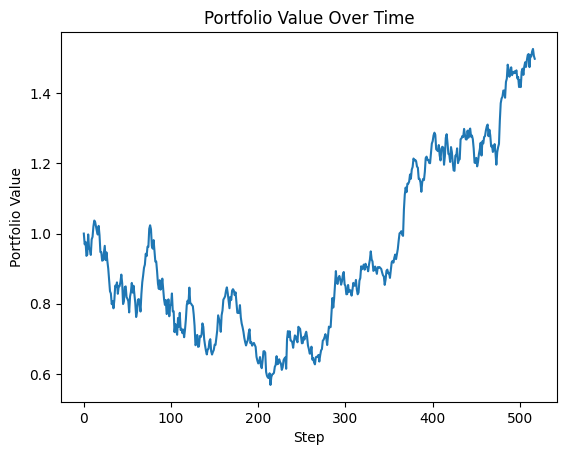

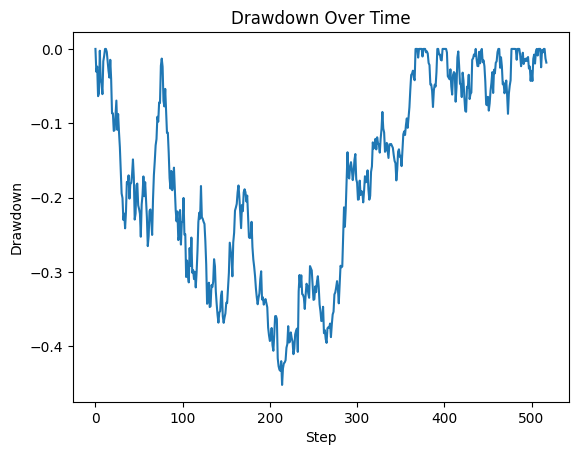

In [33]:
import matplotlib.pyplot as plt

# Equity curve
plt.plot(portfolio_vals)
plt.title("Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.show()

# Drawdown
p = np.array(portfolio_vals)
dd = (p - np.maximum.accumulate(p)) / np.maximum.accumulate(p)
plt.plot(dd)
plt.title("Drawdown Over Time")
plt.xlabel("Step")
plt.ylabel("Drawdown")
plt.show()


In [84]:
# Create fixed test environment (same data for all agents)
test_env = SimplePortfolioEnv(
    tickers=['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AMD'],
    start_date='2022-01-01',
    end_date='2023-12-31',
    window_size=5
)

# Helper: Evaluation loop
def evaluate_agent(agent, env, name="Agent", deterministic=True):
    obs, _ = env.reset(seed=42)  # fixed start
    rets = []
    vals = [env.portfolio_value]
    for _ in range(env.max_steps):
        action, _ = agent.predict(obs, deterministic=deterministic)
        obs, reward, done, _, _ = env.step(action)
        rets.append(reward)
        vals.append(env.portfolio_value)
        if done: break
    return rets, vals

# Meta-controller logic
def combine_actions(a1, a2, alpha):
    combined = alpha * a1 + (1 - alpha) * a2
    combined = np.clip(combined, 1e-8, 1.0)
    return combined / np.sum(combined)

def calculate_volatility(obs_window):
    return np.std(np.array(obs_window))

def get_dynamic_alpha(volatility, threshold=0.02):
    return 1 / (1 + np.exp(10 * (volatility - threshold)))

# Evaluate meta-controller
def evaluate_meta_controller(env, ppo_model, ddpg_model):
    obs, _ = env.reset(seed=42)
    meta_vals = [test_env.portfolio_value]
    meta_daily_rets = []
    volatilities = []
    alphas = []

    for _ in range(test_env.max_steps):
        volatility = calculate_volatility(obs)
        alpha = get_dynamic_alpha(volatility)

        a1, _ = short_term_model.predict(obs, deterministic=True)
        a2, _ = long_term_model.predict(obs, deterministic=True)
        final_action = combine_actions(a1, a2, alpha)

        obs, reward, done, _, _ = test_env.step(final_action)

        meta_daily_rets.append(reward)
        meta_vals.append(test_env.portfolio_value)
        volatilities.append(volatility)
        alphas.append(alpha)

        if done:
            break
    # Add a return statement to return the desired values
    return meta_daily_rets, meta_vals, volatilities, alphas

[*********************100%***********************]  8 of 8 completed


In [108]:
# --- Evaluation ---
ppo_returns, ppo_vals = evaluate_agent(short_term_model, test_env, name="PPO")
# test_env = SimplePortfolioEnv(…, start_date='2022-01-01', end_date='2023-12-31', window_size=5)  # re-initialize
ddpg_returns, ddpg_vals = evaluate_agent(long_term_model, test_env, name="DDPG")
# test_env = SimplePortfolioEnv(…, start_date='2022-01-01', end_date='2023-12-31', window_size=5)
meta_returns, meta_vals,volatilities, aplhas = evaluate_meta_controller(test_env, short_term_model, long_term_model)

# --- Metrics functions ---
def ann_return(rets): return (1 + np.mean(rets)) ** 252 - 1
def ann_vol(rets): return np.std(rets) * np.sqrt(252)
def sharpe(rets): return np.mean(rets) / (np.std(rets) + 1e-8) * np.sqrt(252)
def mdd(vals):
    p = np.array(vals)
    peak = np.maximum.accumulate(p)
    dd = (p - peak) / peak
    return np.min(dd)

# --- Display ---
def print_metrics(name, rets, vals):
    print(f"--- {name} ---")
    print(f"Annualized Return : {ann_return(rets):.2%}")
    print(f"Annualized Vol    : {ann_vol(rets):.2%}")
    print(f"Sharpe Ratio      : {sharpe(rets):.2f}")
    print(f"Max Drawdown      : {mdd(vals):.2%}")
    print()

print_metrics("PPO", ppo_returns, ppo_vals)
print_metrics("DDPG", ddpg_returns, ddpg_vals)
print_metrics("Meta-Controller", meta_returns, meta_vals)


--- PPO ---
Annualized Return : 115.91%
Annualized Vol    : 29.53%
Sharpe Ratio      : 2.61
Max Drawdown      : -9.01%

--- DDPG ---
Annualized Return : 158.17%
Annualized Vol    : 32.63%
Sharpe Ratio      : 2.91
Max Drawdown      : -15.95%

--- Meta-Controller ---
Annualized Return : 175.10%
Annualized Vol    : 15.75%
Sharpe Ratio      : 6.44
Max Drawdown      : -2.45%



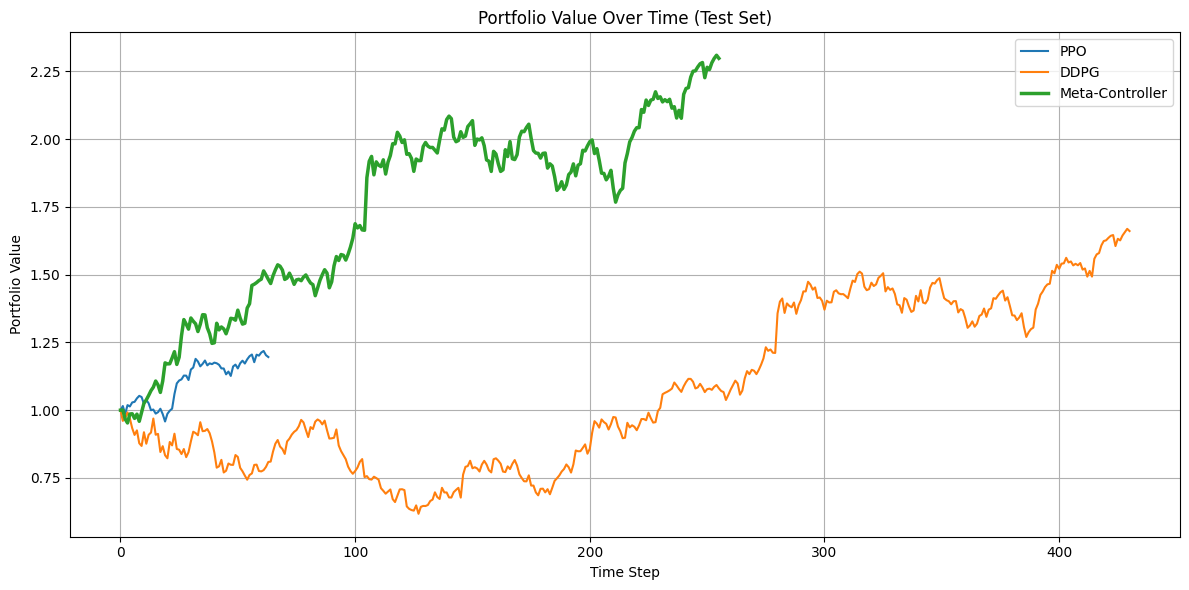

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ppo_vals, label="PPO")
plt.plot(ddpg_vals, label="DDPG")
plt.plot(meta_vals, label="Meta-Controller", linewidth=2.5)
plt.title("Portfolio Value Over Time (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


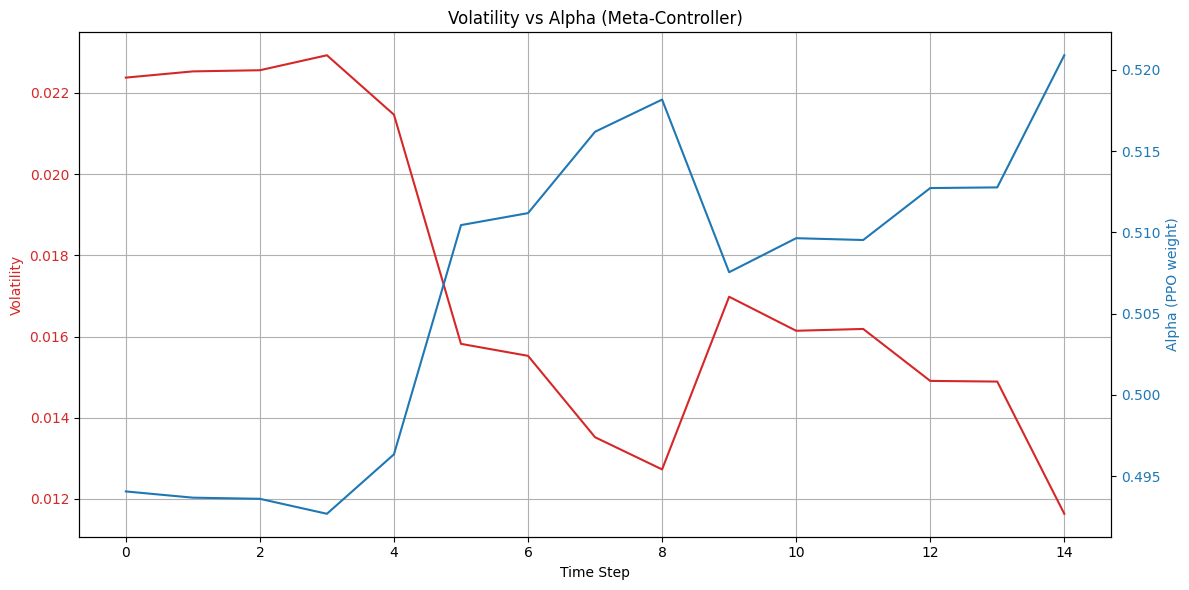

In [111]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot volatility
color = 'tab:red'
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Volatility', color=color)
ax1.plot(volatilities, color=color, label='Volatility')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Add second y-axis for alpha
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Alpha (PPO weight)', color=color)
ax2.plot(aplhas, color=color, label='Alpha (PPO)')
ax2.tick_params(axis='y', labelcolor=color)

# Add legends and title
plt.title('Volatility vs Alpha (Meta-Controller)')
fig.tight_layout()
plt.show()
